In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import files into DataFrames using pandas and drop duplicate and null values for each file
cabData = pd.read_csv('Cab_Data.csv', index_col=False)
cabData.dropna(subset=cabData.columns, inplace=True)
cabData.drop_duplicates(subset=['Transaction ID'], inplace=True)
cityData = pd.read_csv('City.csv', index_col=False)
cityData.dropna(subset=cityData.columns, inplace=True)
cityData.drop_duplicates(subset=['City'], inplace=True)
customerData = pd.read_csv('Customer_ID.csv', index_col=False)
customerData.dropna(subset=customerData.columns, inplace=True)
customerData.drop_duplicates(subset=['Customer ID'], inplace=True)
transactionData = pd.read_csv('Transaction_ID.csv', index_col=False)
transactionData.dropna(subset=transactionData.columns, inplace=True)
transactionData.drop_duplicates(subset=['Transaction ID'], inplace=True)
#perform merges
transactionData = transactionData.merge(customerData, on="Customer ID", how='left')
cabData = cabData.merge(transactionData, on="Transaction ID", how="left")
#convert numeric columns to proper int format and separate month and year from date to make analysis easier
cityData.loc[:, 'Population'] = cityData['Population'].str.replace(',', '').astype(int)
cityData.loc[:, 'Users'] = cityData['Users'].str.replace(",", "").astype(int)
cabData.loc[:, 'Year'] = cabData['Date of Travel'].str.split("/").str[2]
cabData.loc[:, 'Month'] = cabData['Date of Travel'].str.split("/").str[0]
#remove null rows and duplicate transactions from merged database
cityData.dropna(subset=cityData.columns, inplace=True)
cabData.dropna(subset=cabData.columns, inplace=True)
cabData.drop_duplicates(subset=['Transaction ID'], inplace=True)

In [2]:
#perform outlier detection based on distance traveled and price charged
firstQ = cabData['KM Travelled'].quantile(.25)
thirdQ = cabData['KM Travelled'].quantile(.75)
iqr = thirdQ - firstQ
priceFirstQ = cabData['Price Charged'].quantile(.25)
priceThirdQ = cabData['Price Charged'].quantile(.75)
priceIQR = priceThirdQ - priceFirstQ
costFirstQ = cabData['Cost of Trip'].quantile(.25)
costThirdQ = cabData['Cost of Trip'].quantile(.75)
costIQR = costThirdQ - costFirstQ
indexesToDrop = []
for i in range(len(cabData['KM Travelled'])):
    if (cabData['KM Travelled'][i] < firstQ - 1.5*iqr or cabData['KM Travelled'][i] > thirdQ + 1.5*iqr or cabData['Price Charged'][i] < priceFirstQ - 1.5*priceIQR or 
        cabData['Price Charged'][i] > priceThirdQ + 1.5*priceIQR or cabData['Cost of Trip'][i] < costFirstQ - 1.5*costIQR or cabData['Cost of Trip'][i] > costThirdQ + 1.5*costIQR):
        indexesToDrop += [i]
cabData.drop(indexesToDrop, inplace=True)

In [3]:
#add more columns to aid in analysis
cabData.loc[:, 'Profit'] = cabData['Price Charged'] - cabData['Cost of Trip']
cabData.loc[:, 'Profit Margin'] = (cabData['Profit']/cabData['Price Charged'])*100
def defineIncomeGroup(x):
    if x > 10000:
        return '> 10,000'
    elif x < 5000:
        return '< 5,000'
    else:
        return '5,000 to 10,000'
cabData.loc[:, 'Income Category'] = cabData['Income (USD/Month)'].apply(defineIncomeGroup)


<Axes: xlabel='Month', ylabel='Total Gross Revenue'>

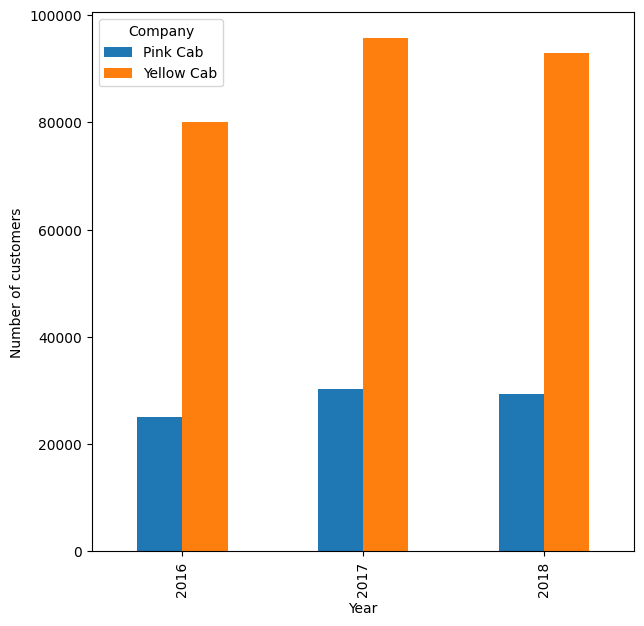

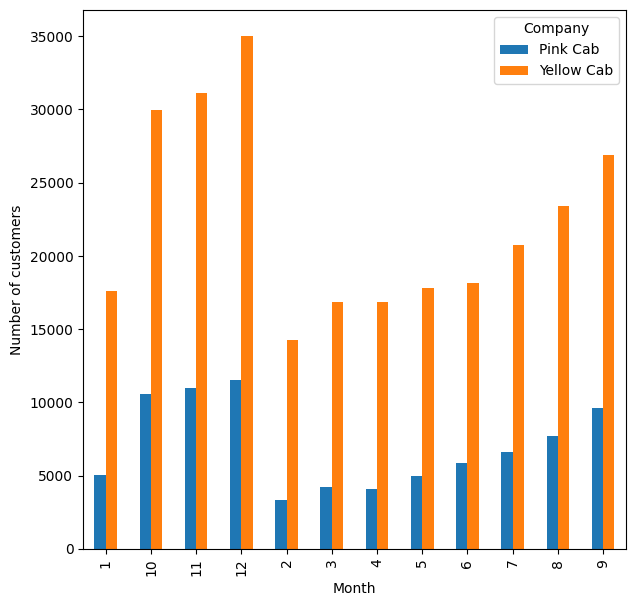

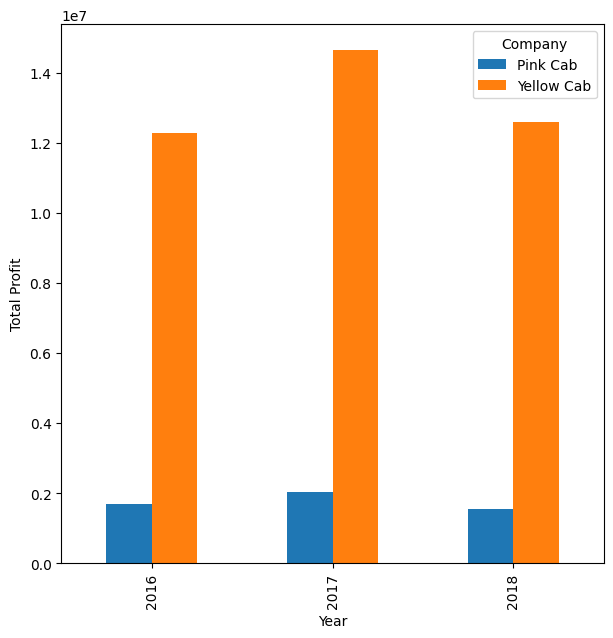

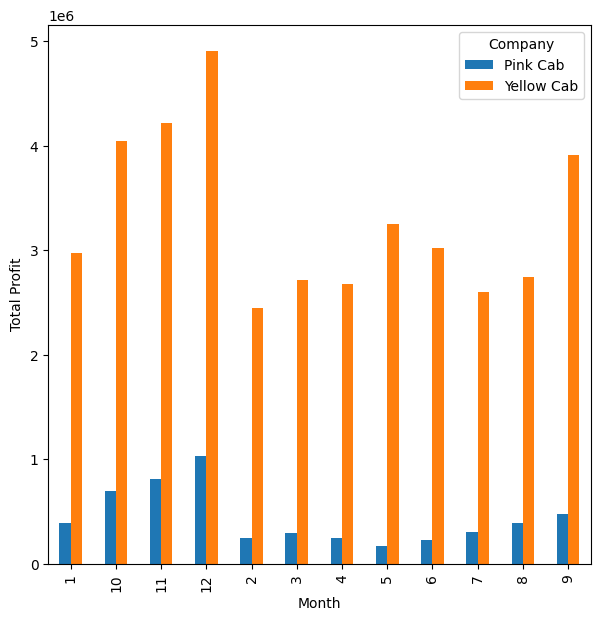

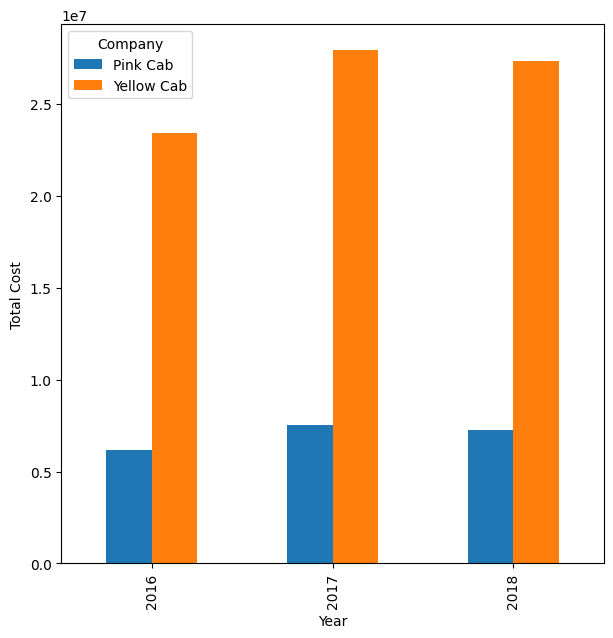

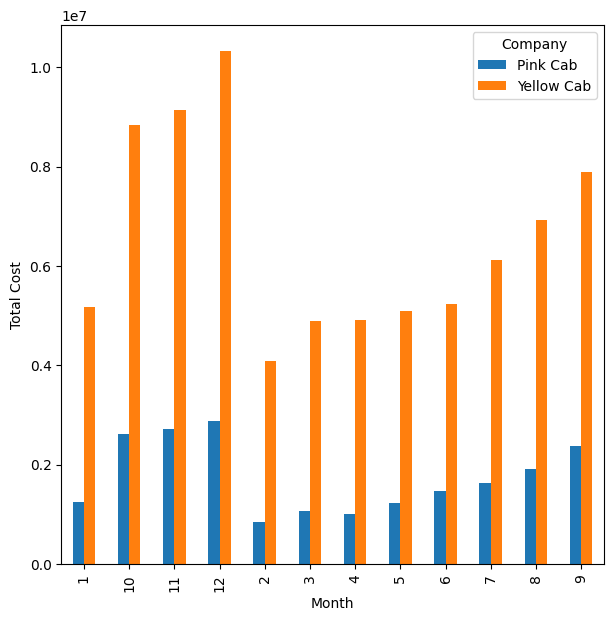

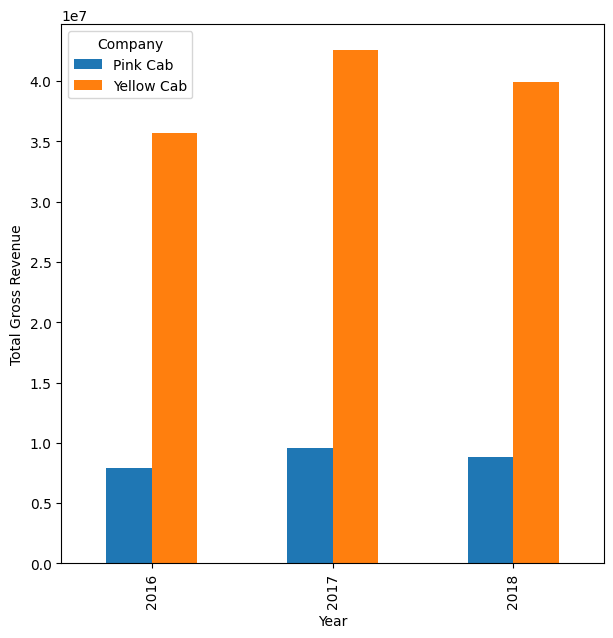

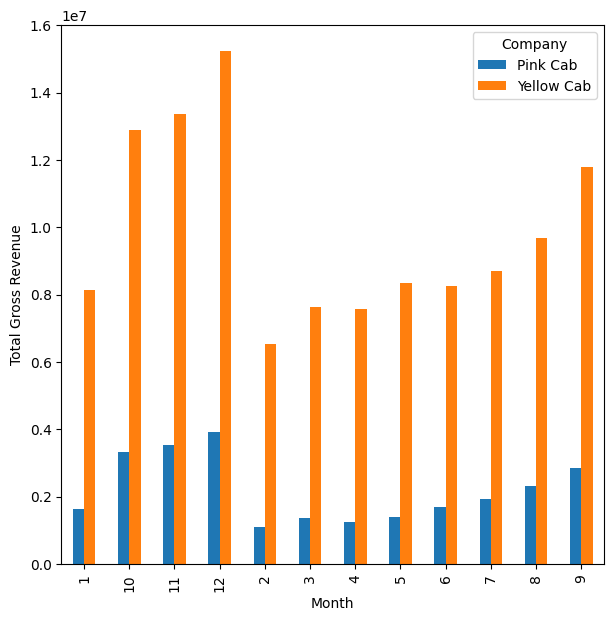

In [4]:
#Hypothesis No.1 --- There is some seasonality in the number of customers and profit made for each company 
cabData.groupby(['Year', 'Company'])['Transaction ID'].nunique().unstack().plot(kind="bar", ylabel='Number of customers', figsize=(7,7))
cabData.groupby(['Month', 'Company'])['Transaction ID'].nunique().unstack().plot(kind="bar", ylabel='Number of customers', figsize=(7,7))
cabData.groupby(['Year', 'Company'])['Profit'].sum().unstack().plot(kind="bar", ylabel="Total Profit", figsize=(7,7))
cabData.groupby(['Month', 'Company'])['Profit'].sum().unstack().plot(kind = 'bar', ylabel="Total Profit", figsize=(7,7))
cabData.groupby(['Year', 'Company'])['Cost of Trip'].sum().unstack().plot(kind="bar", ylabel="Total Cost", figsize=(7,7))
cabData.groupby(['Month', 'Company'])['Cost of Trip'].sum().unstack().plot(kind = 'bar', ylabel="Total Cost", figsize=(7,7))
cabData.groupby(['Year', 'Company'])['Price Charged'].sum().unstack().plot(kind="bar", ylabel="Total Gross Revenue", figsize=(7,7))
cabData.groupby(['Month', 'Company'])['Price Charged'].sum().unstack().plot(kind = 'bar', ylabel="Total Gross Revenue", figsize=(7,7))

<Axes: xlabel='Month', ylabel='Profit Margin %'>

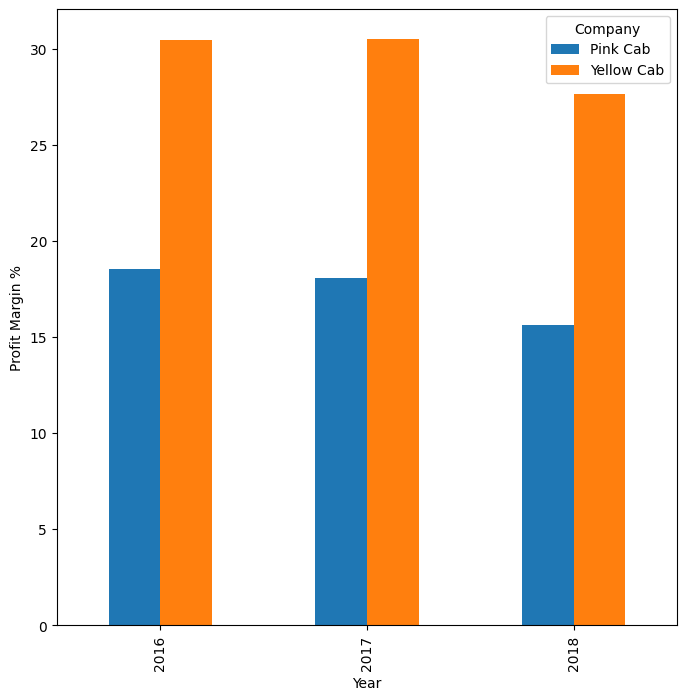

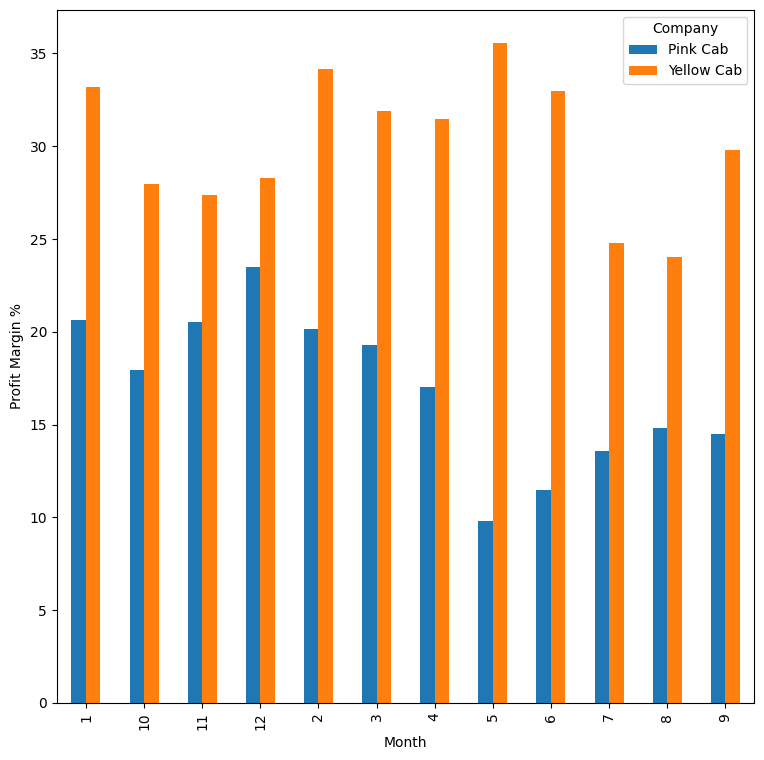

In [5]:
#Hypothesis No.2 --- The average yearly and monthly profit margin for each company is uniform and similar(each company makes back the same percentage on their gross income in net income after subtracting costs)
cabData.groupby(['Year', 'Company'])['Profit Margin'].mean().unstack().plot(kind="bar", ylabel="Profit Margin %", figsize=(7,7))
cabData.groupby(['Month', 'Company'])['Profit Margin'].mean().unstack().plot(kind="bar", ylabel="Profit Margin %", figsize=(9,9))


<Axes: xlabel='City'>

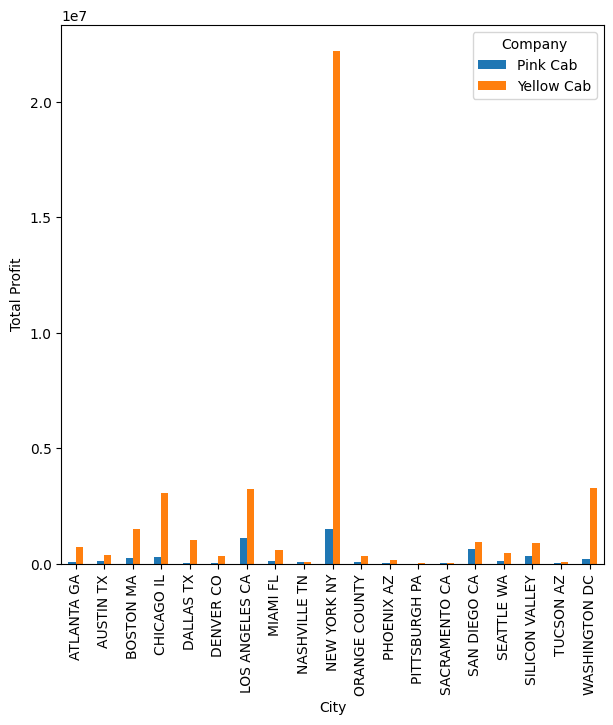

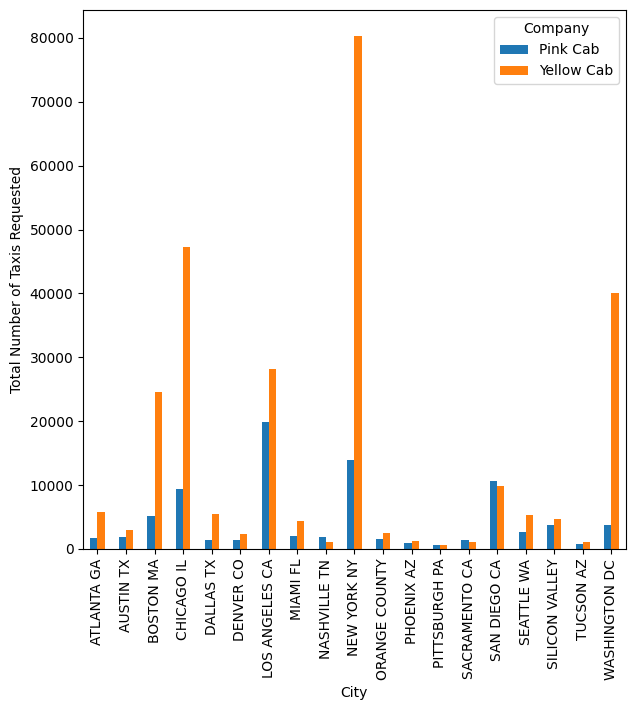

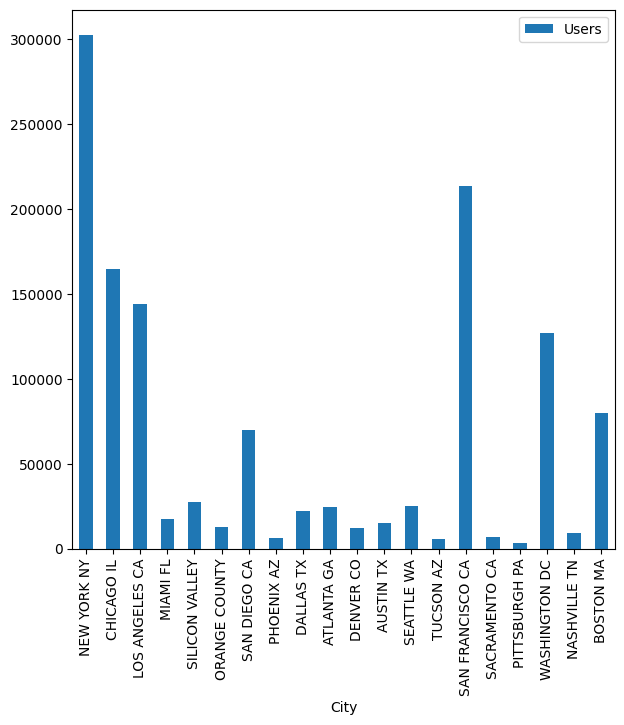

In [6]:
#Hypothesis No. 3 -- The total profit of each company and the number of taxis requested for each company is uniform and similar across all cities in the dataset
cabData.groupby(['City', 'Company'])['Profit'].sum().unstack().plot(kind="bar",ylabel="Total Profit", figsize=(7,7))
cabData.groupby(['City', 'Company'])['Transaction ID'].nunique().unstack().plot(kind="bar",ylabel="Total Number of Taxis Requested", figsize=(7,7))
cityData.plot(kind="bar", y="Users", x="City", figsize=(7,7))

<Axes: xlabel='City,Gender', ylabel='Total Number of Taxis Requested Per City'>

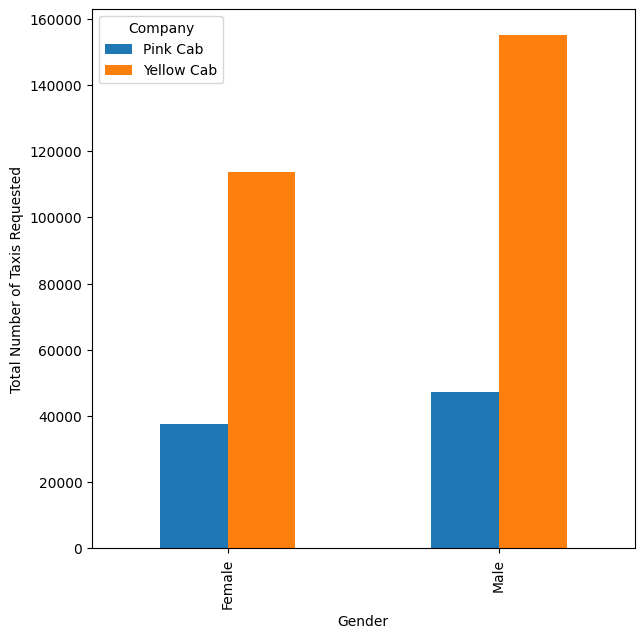

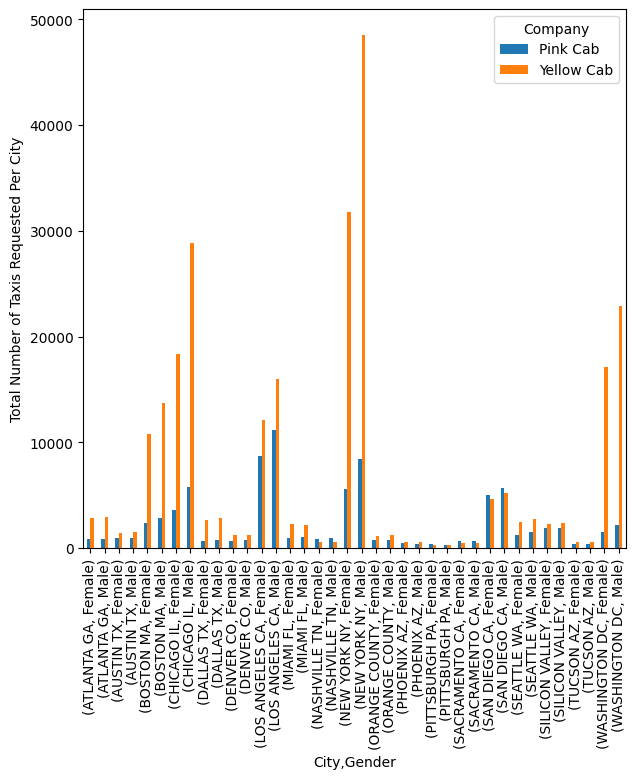

In [7]:
#Hypothesis No. 4 --- There is no gender bias between the two companies, people of both genders ride taxis with both companies an equal amount across all cities
cabData.groupby(['Gender', 'Company'])['Transaction ID'].nunique().unstack().plot(kind="bar",ylabel="Total Number of Taxis Requested", figsize=(7,7))
cabData.groupby(['City', 'Gender', 'Company'])['Transaction ID'].nunique().unstack().plot(kind="bar",ylabel="Total Number of Taxis Requested Per City", figsize=(7,7))

<Axes: xlabel='City,Income Category', ylabel='Total Number of Taxis Requested Per City'>

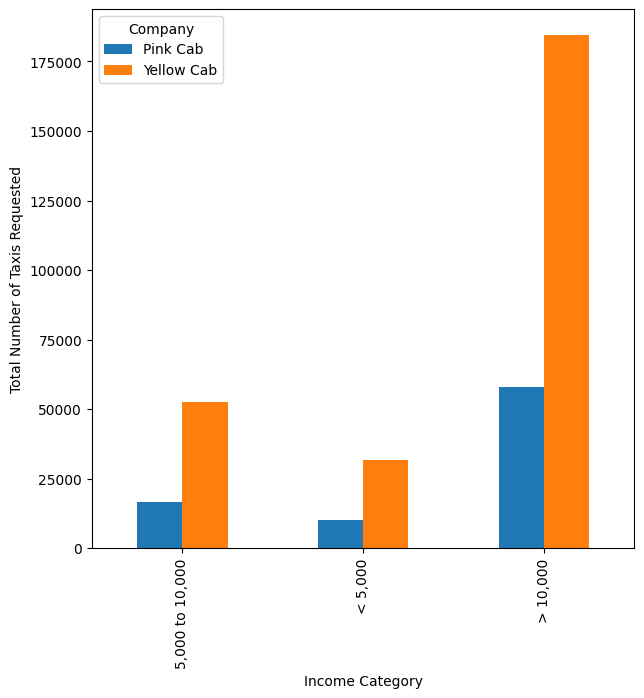

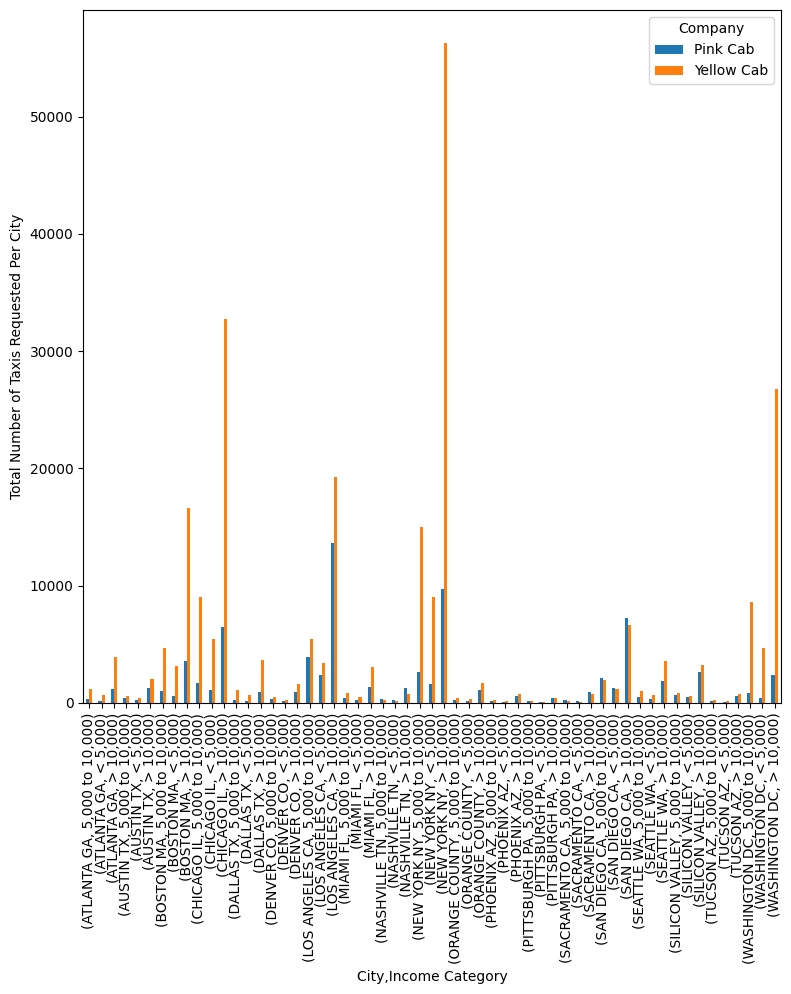

In [8]:
#Hypothesis No. 5 --- There is no income bias between the two companies, people across all incomes ride taxis with both companies
cabData.groupby(['Income Category', 'Company'])['Transaction ID'].nunique().unstack().plot(kind="bar",ylabel="Total Number of Taxis Requested", figsize=(7,7))
cabData.groupby(['City', 'Income Category', 'Company'])['Transaction ID'].nunique().unstack().plot(kind="bar",ylabel="Total Number of Taxis Requested Per City", figsize=(9,9))

In [9]:
#Hypothesis Results and EDA Recommendation

'''Hypothesis No.1 --- There is some seasonality in the number of customers and profit made for each company. It seems that the total profit and number of customers for each company is higher in the winter season(October, November, December), while it is lower for both
    companies for the rest of the year. One key thing to notice is that the total profit and number of customers is substantially higher year-round across all 3 years for Yellow Company than it is for Pink Company. Yellow Company also has a higher monthly/yearly total cost
    but this is more likely to be due to them attracting more consumers than an actual difference in cost between the two companies. Yellow Company also has charged more in total for their cabs on both a monthly and yearly basis, which would explain why they have a higher
    total profit despite having a higher cost.
'''

'''Hypothesis No.2 --- While the average yearly profit margin for both companies is pretty uniform respectively, the average monthly profit margin varies a lot more. Across all 3 years, and all the months, Yellow Company has a higher average profit margin
    across all transactions than Pink Company. This means that on average, Yellow Company will make back more money on the revenue per trip after subtracting costs than Pink Company.
'''    
'''Hypothesis No. 3 ---  The profit and number of taxis requested per city is not uniform and similar for both companies. For Yellow Company, they on average have more taxis requested and generate more profit in all cities. In addition, Yellow Company seems to attract more 
customers than Pink Company in cities such as NY, LA, DC, Chicago, and Boston, which are amongst the cities with the highest amount of users. The only city where Pink Company attracts more customers is San Diego, which also has a relatively smaller amount of users. 
Interestingly, San Francisco has a high number of users, yet neither company is able to attract customers in San Francisco, which is likely dominated by some other taxi company'''

'''Hypothesis No.4 --- For both companies, there seems to be a higher number of males requesting taxis than females. In addition, For both genders, Yellow Cab has a higher outreach than Pink Cab. Even across all cities, Yellow Cab remains the dominant choice
for both genders, with the only exception being San Diego, where customers of both genders request slightly more taxis from Pink Company than Yellow Company,'''

'''Hypothesis No.5 --- For both companies, there seems to be an income bias towards customers with highly monthly incomes, who tend to ride more than customers with lower monthly incomes. This is true across all cities as well, where users with lower incomes tend
to request a less number of taxis than users with a higher income. In addition, it seems that across all income groups and a majority of cities, Yellow Company attracts more customers than Pink Company. Pink Company only attracts more customers than Yellow
Company in San Diego, and with customers who make more than 10,000 USD Monthly.'''

'''From the hypotheses and data, we can see that Yellow Company generates more revenue and more profit than Pink Company, and has a higher outreach of customers from various demographics and various cities than Pink Company. Although Yellow Company has a higher total 
monthly/yearly cost, this is offset by the higher average profit margin and total profit of Yellow Company. Based on this information, I would recommend to Invest in Yellow Company'''
cabData.to_csv('finalCabData.csv', index=False)